In [1]:
%load_ext lab_black
%cd ..

/home/shim/cev/dl/motion-keypoint


In [2]:
import math
import os
import random
import shutil
import json
import logging
import sys
from collections import defaultdict
from datetime import datetime
from io import TextIOWrapper
from pathlib import Path
from typing import Callable, List, Sequence, Tuple

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm

import utils
import networks

In [3]:
model = networks.EfficientDet("efficientdet-d2", pretrained=True)

Load pretrained /home/shim/.cache/torch/hub/checkpoints/efficientdet-d2.pth


In [4]:
conv_a = model.model.classifier.header.pointwise_conv.conv

In [5]:
conv_a

Conv2d(112, 810, kernel_size=(1, 1), stride=(1, 1))

In [6]:
conv_b = nn.Conv2d(conv_a.in_channels, conv_a.out_channels // 90, 1)

In [7]:
conv_b

Conv2d(112, 9, kernel_size=(1, 1), stride=(1, 1))

In [8]:
conv_b.bias.shape

torch.Size([9])

In [9]:
conv_a.weight.shape

torch.Size([810, 112, 1, 1])

In [10]:
bn = nn.BatchNorm2d(10)

In [11]:
bn.weight

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)

In [12]:
model.model.classifier.header

SeparableConvBlock(
  (depthwise_conv): Conv2dStaticSamePadding(
    (conv): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), groups=112, bias=False)
  )
  (pointwise_conv): Conv2dStaticSamePadding(
    (conv): Conv2d(112, 810, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [13]:
# conv, bn, classifier의 num_classes, 모델의 num_classes

In [4]:
model.eval()
torch.set_grad_enabled(False)
pass

In [5]:
mean = torch.tensor((0.485, 0.456, 0.406), dtype=torch.float32).reshape(1, 3, 1, 1)
std = torch.tensor((0.229, 0.224, 0.225), dtype=torch.float32).reshape(1, 3, 1, 1)

In [6]:
im = imageio.imread("data/ori/train_imgs/001-1-1-01-Z17_A-0000001.jpg")

이미지 사이즈가 128의 배수여야만 함.  
X축은 train에서 keypoint가 400~1500 내에 분포하고 있으므로, 374~1526 으로 1152사이즈.  
Y축은 102~998로 896사이즈.

In [7]:
x = im[28:1052, 192:1728]

In [8]:
x.shape

(1024, 1536, 3)

In [28]:
x = cv2.resize(x, (768, 512))

In [9]:
x = torch.tensor(x, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).div(255.0)

In [10]:
x = (x - mean) / std

In [31]:
regression, classification, anchors = model(x, do_postprocess=False)

In [32]:
regression.shape

torch.Size([1, 73656, 4])

In [52]:
regression[0, 2]

tensor([ 0.0040,  0.1389,  0.5434, -2.9724])

In [34]:
classification.shape

torch.Size([1, 73656, 90])

In [35]:
classification[0, 0]

tensor([0.2239, 0.0523, 0.1325, 0.0287, 0.0781, 0.0400, 0.0382, 0.0533, 0.1598,
        0.0364, 0.0196, 0.0004, 0.0255, 0.0157, 0.0715, 0.0921, 0.0136, 0.0393,
        0.0215, 0.0167, 0.0291, 0.0314, 0.0148, 0.0172, 0.0145, 0.0004, 0.0373,
        0.0693, 0.0004, 0.0004, 0.0352, 0.0291, 0.0227, 0.0306, 0.0435, 0.0321,
        0.0490, 0.0781, 0.0204, 0.0209, 0.0484, 0.0588, 0.0238, 0.0327, 0.0004,
        0.0175, 0.0149, 0.0144, 0.0181, 0.0114, 0.0153, 0.0132, 0.0092, 0.0081,
        0.0092, 0.0084, 0.0128, 0.0113, 0.0113, 0.0096, 0.0096, 0.0706, 0.0148,
        0.0318, 0.0158, 0.0004, 0.0193, 0.0004, 0.0003, 0.0141, 0.0004, 0.0226,
        0.0153, 0.0176, 0.0226, 0.0160, 0.0336, 0.0093, 0.0124, 0.0069, 0.0152,
        0.0090, 0.0004, 0.0199, 0.0476, 0.0174, 0.0224, 0.0104, 0.0085, 0.0176])

In [36]:
anchors.shape

torch.Size([1, 73656, 4])

In [49]:
anchors[0, 1]

tensor([ -7.2000, -18.4000,  15.2000,  26.4000])

In [75]:
x.shape

torch.Size([1, 3, 1024, 1536])

In [11]:
regression, classification, anchors = model(x, sizes=[(1536, 1024), (768, 512)], do_flip_test=True, do_postprocess=False)

In [12]:
regression.shape

torch.Size([1, 736560, 4])

In [13]:
classification.shape

torch.Size([1, 736560, 90])

In [14]:
anchors.shape

torch.Size([1, 736560, 4])

In [25]:
outs = model(x, sizes=[(1536, 1024), (768, 512)], do_flip_test=True, do_postprocess=True)

In [27]:
p = outs[0]
box = p["rois"][p["class_ids"] == 0][p["scores"][p["class_ids"] == 0].argmax()]

In [28]:
box = box.astype(np.int)

In [29]:
box

array([755, 258, 957, 841])

In [30]:
im_out = utils.denormalize(x).squeeze(0).permute(1, 2, 0).mul(255.0).type(torch.uint8).numpy()

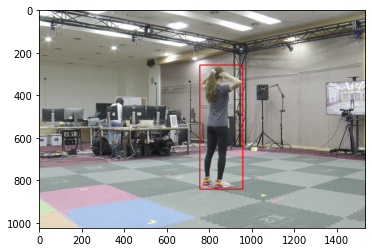

In [31]:
plt.imshow(cv2.rectangle(im_out, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3))

In [20]:
out = networks.efficientdet.postprocess(x, anchors, regression, classification)
out

[{'rois': array([[755.2759  , 258.84006 , 957.7666  , 841.3484  ],
         [376.58508 , 129.60678 , 478.21893 , 421.66483 ],
         [319.59344 , 411.50946 , 396.98914 , 632.82965 ],
         [501.4815  , 447.05484 , 596.9384  , 522.05707 ],
         [  8.019669, 230.98686 ,  59.72348 , 266.82578 ],
         [ 14.452316, 462.38553 , 118.36774 , 534.60724 ],
         [159.54272 , 205.82355 , 199.58832 , 310.8438  ],
         [245.67116 , 589.4672  , 338.44403 , 687.0695  ],
         [113.783714, 461.9909  , 210.94055 , 531.0344  ],
         [ 57.99502 , 230.2995  , 105.03758 , 262.02844 ],
         [109.11557 , 561.0281  , 176.54709 , 662.85034 ],
         [400.71057 , 511.40323 , 504.28735 , 628.06256 ],
         [613.63934 , 492.53885 , 653.21234 , 551.97034 ],
         [123.34817 , 296.93713 , 167.6485  , 343.4909  ],
         [612.64703 , 490.96228 , 654.23785 , 553.412   ],
         [468.92944 , 517.0909  , 538.5764  , 548.78546 ],
         [ 51.789604, 280.10022 , 101.47625 , 33

In [21]:
p = out[0]
box = p["rois"][p["class_ids"] == 0][p["scores"][p["class_ids"] == 0].argmax()]

In [22]:
box = box.astype(np.int)

In [23]:
box

array([755, 258, 957, 841])

In [24]:
im_out = utils.denormalize(x).squeeze(0).permute(1, 2, 0).mul(255.0).type(torch.uint8).numpy()

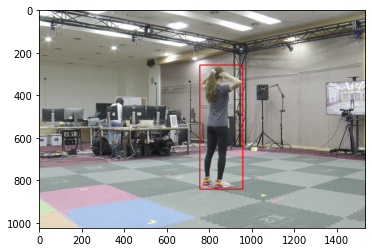

In [25]:
plt.imshow(cv2.rectangle(im_out, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3))

In [18]:
regression.max()

tensor(14.6225)

In [20]:
out = networks.efficientdet.postprocess(x, anchors, regression, classification)

In [21]:
out

[{'rois': array([[571.15814, 191.87143, 777.4261 , 755.0614 ],
         [140.11386, 334.69055, 218.06934, 464.53674],
         [437.29663, 539.3661 , 611.04553, 604.78064],
         [442.63455, 404.24265, 514.8456 , 554.8313 ],
         [322.34857, 375.68747, 417.53693, 444.63913],
         [ 43.12216, 361.0008 , 569.55945, 624.8889 ]], dtype=float32),
  'class_ids': array([ 0,  0, 64,  0, 71, 64]),
  'scores': array([0.8155176 , 0.42299947, 0.30749795, 0.29605412, 0.27031898,
         0.22768965], dtype=float32)}]

In [26]:
p = out[0]

In [31]:
p["rois"][p["class_ids"] == 0][p["scores"][p["class_ids"] == 0].argmax()]

array([571.15814, 191.87143, 777.4261 , 755.0614 ], dtype=float32)

In [38]:
im_out = x.squeeze(0).permute(1, 2, 0).mul(255.0).type(torch.uint8).numpy()

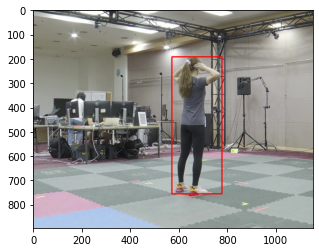

In [40]:
plt.imshow(cv2.rectangle(im_out, (571, 192), (777, 755), (255, 0, 0), 3))

잘 안된 test이미지로 했을 때 잘 인식하는지 확인

In [62]:
im = imageio.imread("data/ori/test_imgs/786-3-5-41-Z94_A-0000007.jpg")
x = im[102:998, 374:1526]
x = torch.tensor(x, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).div(255.0)

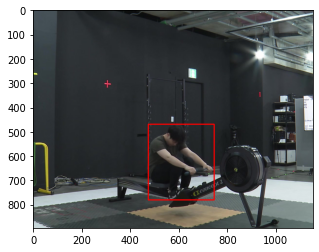

{'rois': array([[ 474.35425 ,  469.91766 ,  745.07495 ,  780.93805 ],
       [ 561.6872  ,  524.9931  , 1026.9727  ,  884.0368  ],
       [ 536.1344  ,  523.51044 , 1015.17163 ,  865.0047  ],
       [ 133.53925 ,   39.109924,  880.45087 ,  658.9827  ],
       [  49.063904,   25.431488,  769.61804 ,  667.77515 ],
       [ 483.09552 ,  472.11652 ,  750.37787 ,  776.3381  ],
       [  46.723938,  684.6527  ,  344.05905 ,  759.3281  ],
       [   3.593155,  542.7375  ,   64.448975,  749.06366 ],
       [ 553.57965 ,  672.4371  ,  793.6529  ,  807.73553 ],
       [ 779.40076 ,  558.276   ,  975.5985  ,  748.2162  ]],
      dtype=float32), 'class_ids': array([ 0, 64,  4,  6, 75, 22, 64, 71,  4, 69]), 'scores': array([0.3835864 , 0.3134873 , 0.29331967, 0.2514856 , 0.22984044,
       0.21871383, 0.21836315, 0.21145667, 0.20927681, 0.20090511],
      dtype=float32)}


In [63]:
_, regression, classification, anchors = model(x)
out = networks.efficientdet.postprocess(x, anchors, regression, classification)
p = out[0]
box = p["rois"][p["class_ids"] == 0][p["scores"][p["class_ids"] == 0].argmax()]
im_out = x.squeeze(0).permute(1, 2, 0).mul(255.0).type(torch.uint8).numpy()
plt.imshow(cv2.rectangle(im_out, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3))
plt.show()
print(p)

In [58]:
im = imageio.imread("data/ori/test_imgs/786-3-5-41-Z94_A-0000007.jpg")
x = im[102:998, 374:1526]
x = torch.tensor(x, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).div(255.0)
x = (x - mean) / std

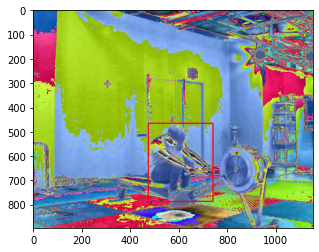

{'rois': array([[474.60437 , 465.6851  , 740.71106 , 786.2998  ],
       [558.47534 , 726.4987  , 690.03674 , 811.1054  ],
       [ 16.95308 , 727.91473 ,  89.68634 , 759.9626  ],
       [635.1935  , 238.04236 , 675.2637  , 284.8994  ],
       [343.642   , 684.0278  , 574.0259  , 789.3669  ],
       [928.38794 , 337.42514 , 939.2389  , 359.0505  ],
       [  5.515335, 537.7236  ,  84.18313 , 755.7736  ]], dtype=float32), 'class_ids': array([ 0, 40, 40, 71, 14,  9, 32]), 'scores': array([0.92605007, 0.6338689 , 0.32081625, 0.31181744, 0.28647944,
       0.2173123 , 0.2028948 ], dtype=float32)}


In [60]:
_, regression, classification, anchors = model(x)
out = networks.efficientdet.postprocess(x, anchors, regression, classification)
p = out[0]
box = p["rois"][p["class_ids"] == 0][p["scores"][p["class_ids"] == 0].argmax()]
im_out = x.squeeze(0).permute(1, 2, 0).mul(255.0).type(torch.uint8).numpy()
plt.imshow(cv2.rectangle(im_out, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3))
plt.show()
print(p)

standardization을 안해주면 score에서 매우 큰 차이가 나는 것을 알 수 있음.

In [10]:
im = imageio.imread("data/ori/test_imgs/730-3-5-36-Z94_A-0000011.jpg")
x = im[102:998, 374:1526]
x = torch.tensor(x, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).div(255.0)
x = (x - mean) / std

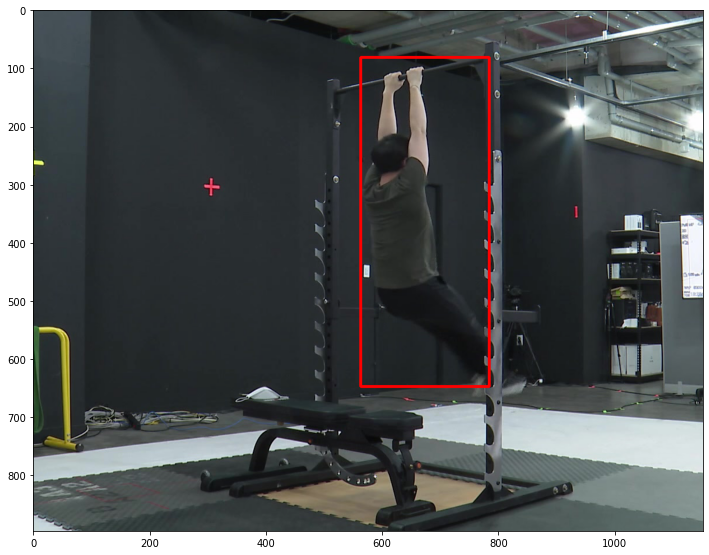

{'rois': array([[ 563.33984  ,   81.40579  ,  784.31946  ,  647.3556   ],
       [  16.980328 ,  728.4754   ,   88.73761  ,  760.3704   ],
       [   4.6439095,  539.063    ,   83.50987  ,  756.7278   ],
       [ 330.3293   ,  678.62225  ,  666.0243   ,  848.5651   ],
       [ 597.5781   ,  800.683    ,  930.8933   ,  890.50977  ],
       [ 336.7782   ,  674.9026   ,  662.808    ,  837.5167   ],
       [ 317.09998  ,  687.5692   ,  652.6547   ,  837.8063   ],
       [1000.6734   ,  434.8479   , 1010.91595  ,  460.4618   ]],
      dtype=float32), 'class_ids': array([ 0, 40, 32, 14, 34,  1, 40, 83]), 'scores': array([0.77076215, 0.34488922, 0.3312984 , 0.2944719 , 0.23433636,
       0.21180324, 0.21062912, 0.20198768], dtype=float32)}


In [14]:
out = model(x)
p = out[0]
box = p["rois"][p["class_ids"] == 0][p["scores"][p["class_ids"] == 0].argmax()]
im_out = x.mul(std).add(mean).squeeze(0).permute(1, 2, 0).mul(255.0).type(torch.uint8).numpy()
plt.figure(figsize=(12, 10))
plt.imshow(cv2.rectangle(im_out, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3))
plt.show()
print(p)

다리부분이 잘 안된걸 볼 수 있음  
하지만 문제가 train 데이터에서는 저렇게 신체 일부가 가려지는 영상이 없다는 것

effdet-d7에서는 될까?

In [7]:
im = imageio.imread("data/ori/test_imgs/730-3-5-36-Z94_A-0000011.jpg")
x = im[102:998, 374:1526]
x = torch.tensor(x, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).div(255.0)
x = (x - mean) / std

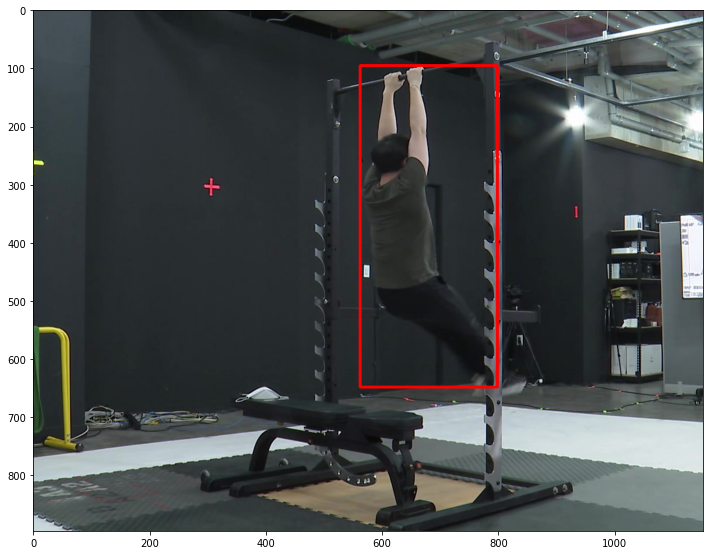

{'rois': array([[562.2527 ,  95.095  , 798.3871 , 648.78284],
       [286.56274, 655.74207, 691.861  , 884.9424 ]], dtype=float32), 'class_ids': array([ 0, 61]), 'scores': array([0.8907248, 0.5758521], dtype=float32)}


In [8]:
out = model(x)
p = out[0]
box = p["rois"][p["class_ids"] == 0][p["scores"][p["class_ids"] == 0].argmax()]
im_out = x.mul(std).add(mean).squeeze(0).permute(1, 2, 0).mul(255.0).type(torch.uint8).numpy()
plt.figure(figsize=(12, 10))
plt.imshow(cv2.rectangle(im_out, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3))
plt.show()
print(p)